# Image Offsets - Centroid precision analysis

Tables generated by the previous notebook (Offsets_2) are used to build some statistics associated with centroiding. 

This is a crucial step in drizzle implementation, since we must assure that the pixel offsets created by this process have sufficient precision to even justify drizzling in the first place. Remember that we are using Bayer RGB raw arrays as a source for centroiding, so color effects may be of importance here.

This script also provides the means to reject stars with large residuals in centroid position, and stars with incomplete coverage along the frame sequence.

Originally this notebook was developed with the ISO 12800 data set as the test data. In the current version, it is configured to use a different data set. Statements specific to the original data set were comented out.

In [1]:
import os, glob
import random
import math
import copy

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
from photutils.aperture import CircularAperture
import rawpy

from datapath import DATA

## Read tables created by previous notebook

In [2]:
# datadir = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/')   # ISO 12800 data set
# datadir = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/6400/light/')    # ISO 6400 data set
datadir = os.path.join(DATA,'astrophotography_data/Andromeda_2022/104p105/')    # Andromeda data set

file_list = glob.glob(datadir + '*.offsets_table.fits')
file_list.sort()

# file_list = list(reversed(file_list))   # ISO 6400 data set

table_list = [Table.read(x) for x in file_list]

## Read image to get array size

In [3]:
# # last table in sequence
# last = file_list[-1]

# # prototype image
# image_name = last.split('/')[-1]
# image_name = image_name.replace('.offsets_table.fits', '.ARW')
# image_name = os.path.join(datadir, image_name)
# raw = rawpy.imread(image_name)
# imarray = raw.raw_image_visible.astype(float)

# ny = imarray.shape[0]
# nx = imarray.shape[1]

# print(nx, ny)

In [4]:
# last table in sequence
last = file_list[-1]

# prototype image
image_name = last.split('/')[-1]
image_name = image_name.replace('.offsets_table.fits', '.bkg_subtracted.fits')
image_name = os.path.join(datadir, image_name)
f = fits.open(image_name)
imarray = f[1].data
f.close()    

ny = imarray.shape[0]
nx = imarray.shape[1]

print(nx, ny)

4256 2848


## Functions

These functions plot centroids (Y against X) as a function of time (or image number in sequence) to gauge the precision to which we can recover the centroid from the highly under-sampled data.

In [5]:
# gets row index of star nearest to the supplied coordinates. 
def get_nearest_index(x, y, table):
    min_dist = math.sqrt(float(nx)**2 + float(ny)**2)
    row_index_min_dist = 0

    for row_index in range(len(table)):
        xcent = table['xcentroid'][row_index]
        ycent = table['ycentroid'][row_index]
        
        dist = math.sqrt((x - xcent)**2 + (y - ycent)**2)
        
        if (dist < min_dist):
            min_dist = dist
            row_index_min_dist = row_index

    return row_index_min_dist

In [6]:
# fits a straight line thru centroids and compute residuals
def fit_line(table_list, input_row_index):
    row_index = input_row_index

    # collect all centroid measurements of the given star
    x_data = []
    y_data = []
    for table_object in reversed(table_list):
    
        x_data.append(table_object['xcentroid'][row_index])
        y_data.append(table_object['ycentroid'][row_index])

        # update row index to point to previous' table row that 
        # corresponds to this star.
        row_index = table_object['prev_row'][row_index]

    # fit straight line and compute residuals
    x_data = np.asarray(x_data)
    y_data = np.asarray(y_data)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)

    pred_values = slope * x_data + intercept
    residuals = y_data - pred_values
    stdev = math.sqrt(np.sum(residuals**2) / len(residuals))
    
    return stdev, slope, intercept, x_data, y_data, residuals

In [7]:
def plot_residuals(x, y, table_list, nearest=False, large_resid=None):

    # last table in sequence 
    table_last = table_list[-1]

    # find in last table, the row corresponding to the input star, 
    # based on centroid column.
    tol = 2.0 # tolerance

    # we assume first, that the x,y coordinates are exact, that is,
    # they match within a tolerance, an existing table row.
    found = False
    for row_index in range(len(table_last)):
        xcent = table_last['xcentroid'][row_index]
        ycent = table_last['ycentroid'][row_index]

        if (abs(x - xcent) < tol and abs( y - ycent) < tol):
            found = True
            break

    # if no row with matching x,y centroids can be found, we can either
    # pick any row at random, or look for the nearest centroid to the 
    # given x,y position.
    if not found:
        if nearest:
            print("Coordinates: ", x, y, ". Picking nearest star.")
            row_index = get_nearest_index(x, y, table_last)
        else:
            print("Cannot find star near ", x, y, ". Picking at random.")
            row_index = random.randrange(len(table_last))

        x = table_last['xcentroid'][row_index]
        y = table_last['ycentroid'][row_index]

    # fit line
    stdev, slope, intercept, x_data, y_data, residuals = fit_line(table_list, row_index)
    
    # plot
    if large_resid is None or (large_resid is not None and stdev > large_resid):
        fig, (ax1, ax2) = plt.subplots(1, 2)
    #     fig.set_size_inches(8.5, 3.5) # interactive notebook
        fig.set_size_inches(12.5, 5.5)

        for xp,yp,r in zip(x_data, y_data, residuals):
            ax1.plot(xp, yp, 'ro')
            ax2.plot(xp, r, 'ro')

        title = 'x = {:.2f} y = {:.2f}'.format(x, y)
        sigma = '\u03C3 = {:.3f}'.format(stdev)

        ax1.grid()
        ax2.grid()
        ax1.set_title(title)
        ax2.set_title(sigma)

        fig.show()

These functions reject stars with large residuals, from all tables.

In [8]:
# keep only the NaN-free entries
def clean_nans(table):
    has_nan = np.zeros(len(table), dtype=bool)
    xcent = np.array(table['xcentroid'])
    has_nan |= np.isnan(xcent)
    return table[~has_nan]

In [9]:
# mark stars based on large residuals
def _mark_residuals(table_list, residual_threshold=0.6):
    # last table in sequence 
    table_last = table_list[-1]
    
    # scan rows in last table
    for last_table_row_index in range(len(table_last)):
        row_index = last_table_row_index

        # fit line for this star
        stdev, slope, intercept, _, _, _ = fit_line(table_list, row_index)
        
        if stdev > residual_threshold:
            print(last_table_row_index, stdev)
            
            # mark this star in all tables
            ri = last_table_row_index
            for table_object in reversed(table_list):
                table_object['xcentroid'][ri] = np.NaN
                ri = table_object['prev_row'][ri]


# Mark stars based on incomplete tracks
def _mark_incomplete(table_list):
    # start with last table
    prev_row = table_list[-1]['prev_row']
    prev_xcentroid = table_list[-1]['xcentroid']
    
    # scan tables from (one before) last to first
    for table in list(reversed(table_list))[1:]:
        
        # first mask will filter out everything that is not
        # pointed at by the previous table
        mask1 = np.ones((len(table)), dtype=bool) # all True
        mask1[prev_row] = False

        # second mask will filter out everything that was already
        # masked in previous table
        mask2 = np.zeros((len(table)), dtype=bool) # all False
        for i in list(range(len(prev_xcentroid))):
            if np.isnan(prev_xcentroid[i]):
                mask2[prev_row[i]] = True

        mask = mask1 | mask2

        table['xcentroid'][mask] = np.NaN
    
        # current row pointers and values are to be 
        # used in next table's processing
        prev_row = table['prev_row']
        prev_xcentroid = table['xcentroid']


def reject_stars(table_list, residual_threshold=0.6):

    # these functions must mark, but no remove rows. Removing
    # rows must be done as the last step in processing, and only
    # once, because it invalidates the row pointers in each table
    # (prev_row and ref_row).

    _mark_residuals(table_list, residual_threshold=residual_threshold)

    _mark_incomplete(table_list)
    
    # once all rows in all tables are marked, remove them.
    table_list_clean = []

    for table in table_list:
        table_list_clean.append(clean_nans(table))

    return table_list_clean

## Plot

The plots are in general consistent with precision of a fraction of one pixel. They seem to warrant the use of drizzle.

Coordinates:  500 500 . Picking nearest star.
Coordinates:  500 1000 . Picking nearest star.


/var/folders/y5/zcwj7zc17g19nggvb1vx4rc80000gn/T/ipykernel_10653/1678248329.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Coordinates:  500 1500 . Picking nearest star.
Coordinates:  500 2000 . Picking nearest star.
Coordinates:  500 2500 . Picking nearest star.
Coordinates:  1000 500 . Picking nearest star.
Coordinates:  1000 1000 . Picking nearest star.
Coordinates:  1000 1500 . Picking nearest star.
Coordinates:  1000 2000 . Picking nearest star.
Coordinates:  1000 2500 . Picking nearest star.
Coordinates:  1500 500 . Picking nearest star.
Coordinates:  1500 1000 . Picking nearest star.
Coordinates:  1500 1500 . Picking nearest star.
Coordinates:  1500 2000 . Picking nearest star.
Coordinates:  1500 2500 . Picking nearest star.
Coordinates:  2000 500 . Picking nearest star.
Coordinates:  2000 1000 . Picking nearest star.
Coordinates:  2000 1500 . Picking nearest star.
Coordinates:  2000 2000 . Picking nearest star.
Coordinates:  2000 2500 . Picking nearest star.
Coordinates:  2500 500 . Picking nearest star.
Coordinates:  2500 1000 . Picking nearest star.


/var/folders/y5/zcwj7zc17g19nggvb1vx4rc80000gn/T/ipykernel_10653/1678248329.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2)


Coordinates:  2500 1500 . Picking nearest star.
Coordinates:  2500 2000 . Picking nearest star.
Coordinates:  2500 2500 . Picking nearest star.
Coordinates:  3000 500 . Picking nearest star.
Coordinates:  3000 1000 . Picking nearest star.
Coordinates:  3000 1500 . Picking nearest star.
Coordinates:  3000 2000 . Picking nearest star.
Coordinates:  3000 2500 . Picking nearest star.
Coordinates:  3500 500 . Picking nearest star.
Coordinates:  3500 1000 . Picking nearest star.
Coordinates:  3500 1500 . Picking nearest star.
Coordinates:  3500 2000 . Picking nearest star.
Coordinates:  3500 2500 . Picking nearest star.
Coordinates:  4000 500 . Picking nearest star.
Coordinates:  4000 1000 . Picking nearest star.
Coordinates:  4000 1500 . Picking nearest star.
Coordinates:  4000 2000 . Picking nearest star.
Coordinates:  4000 2500 . Picking nearest star.


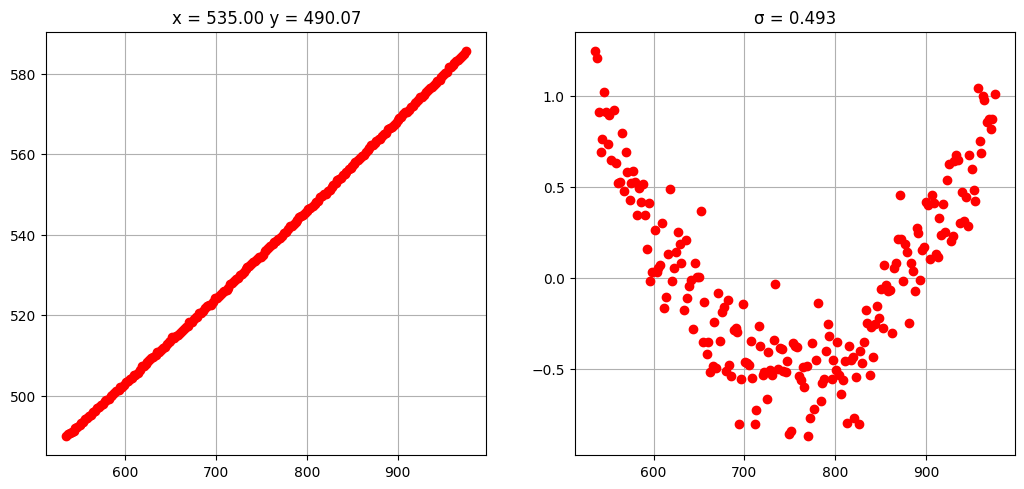

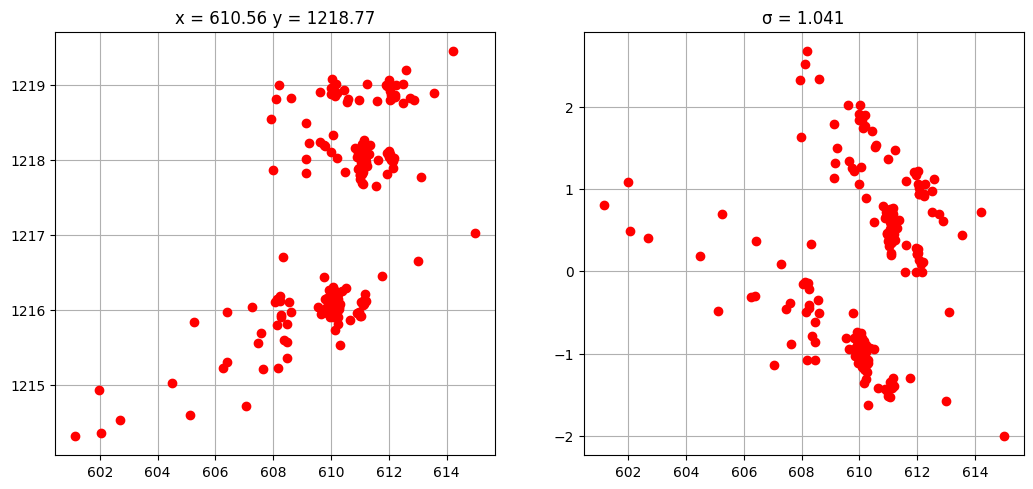

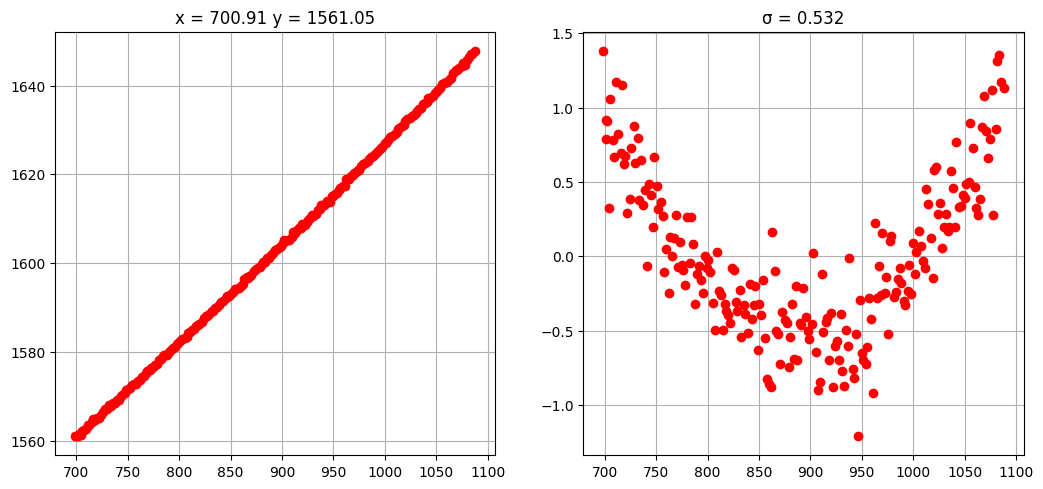

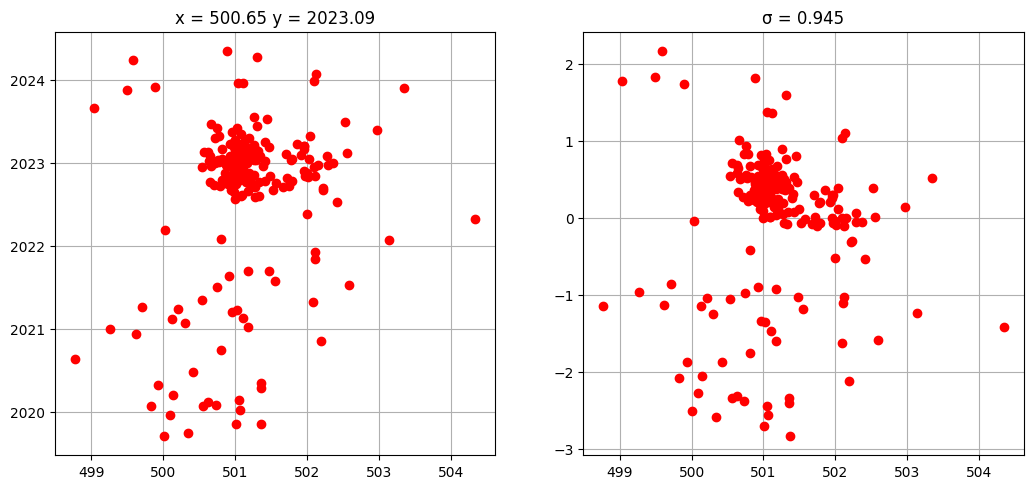

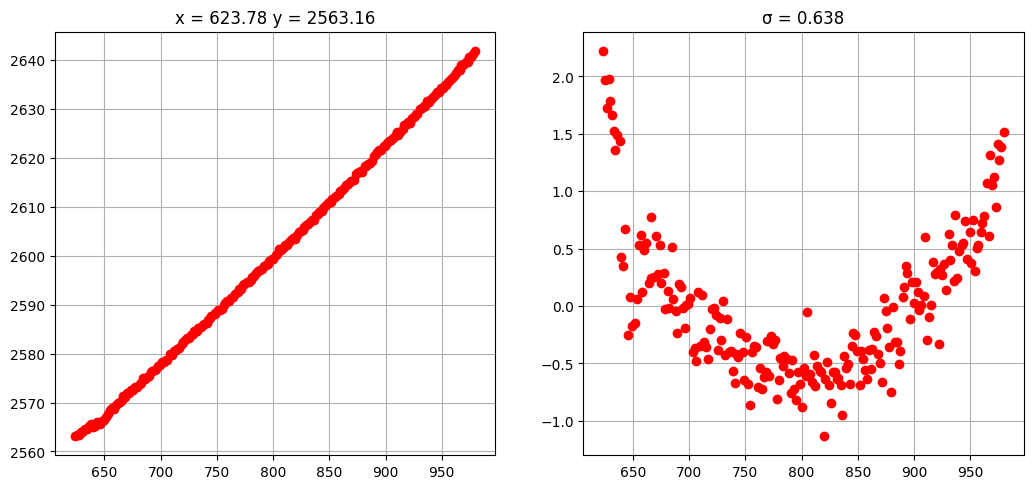

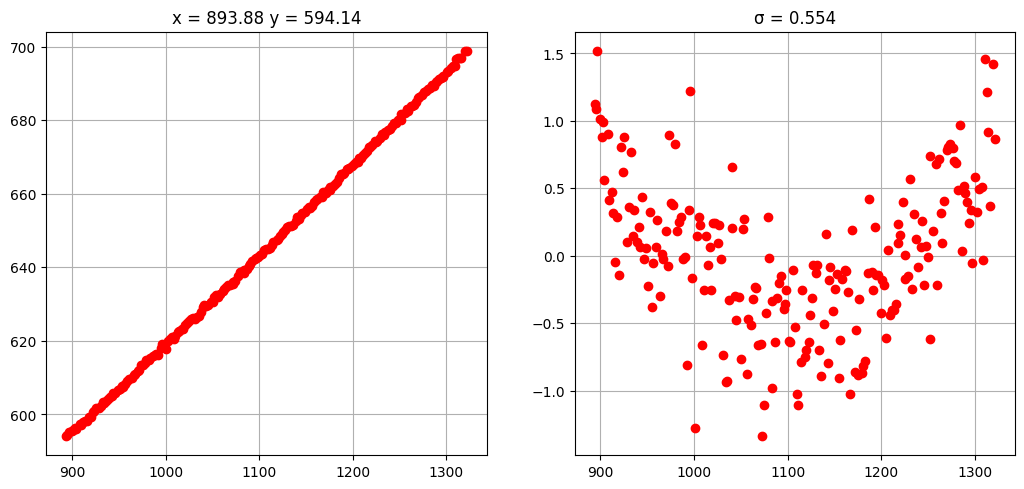

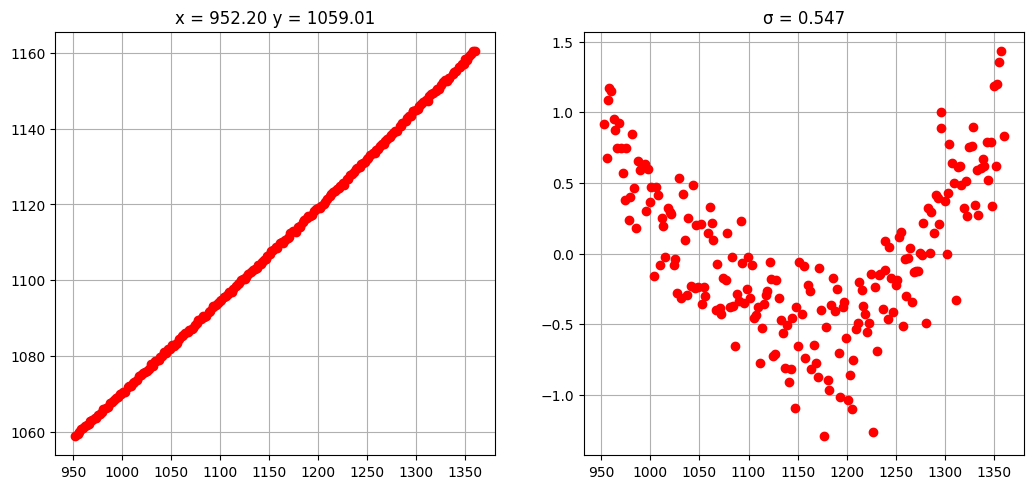

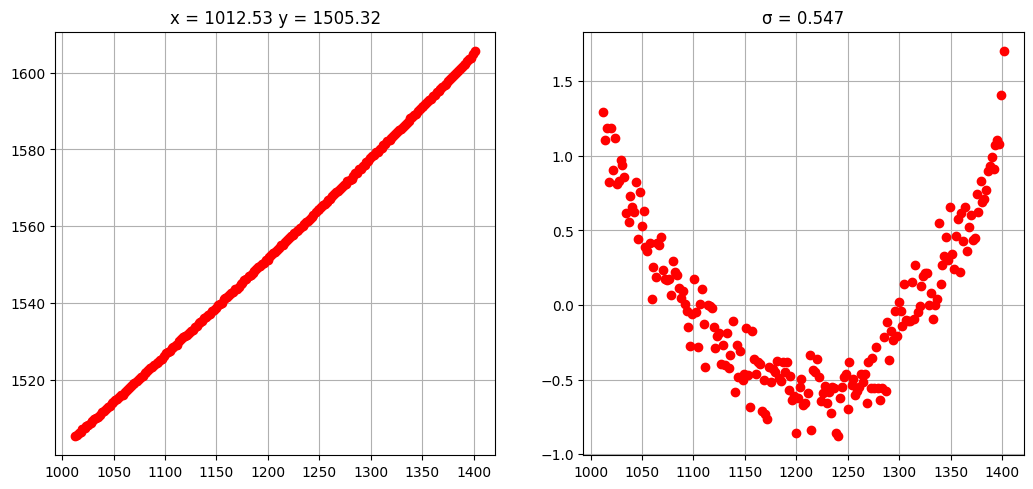

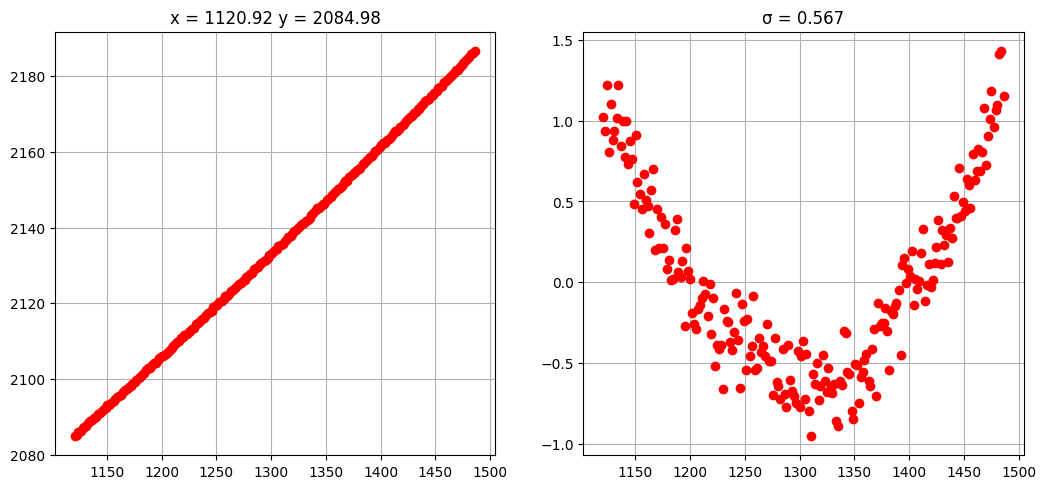

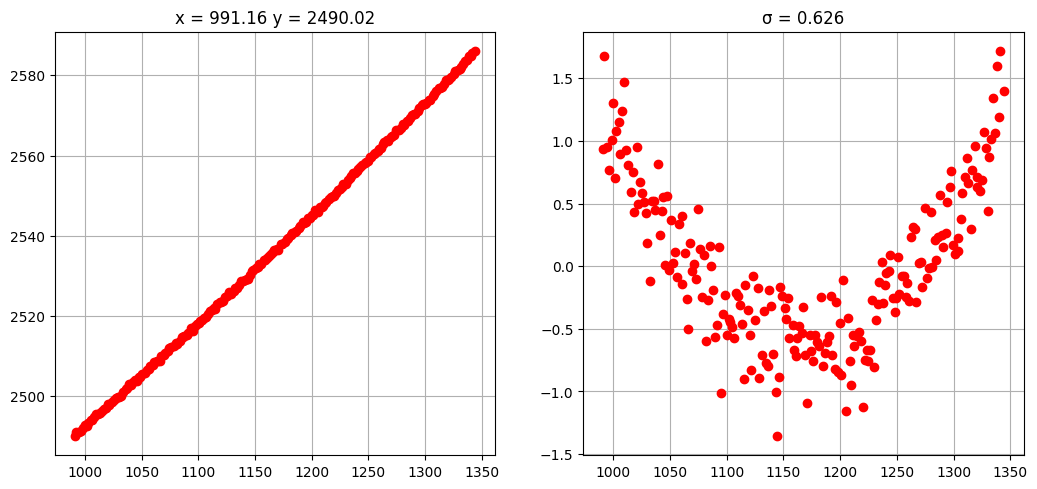

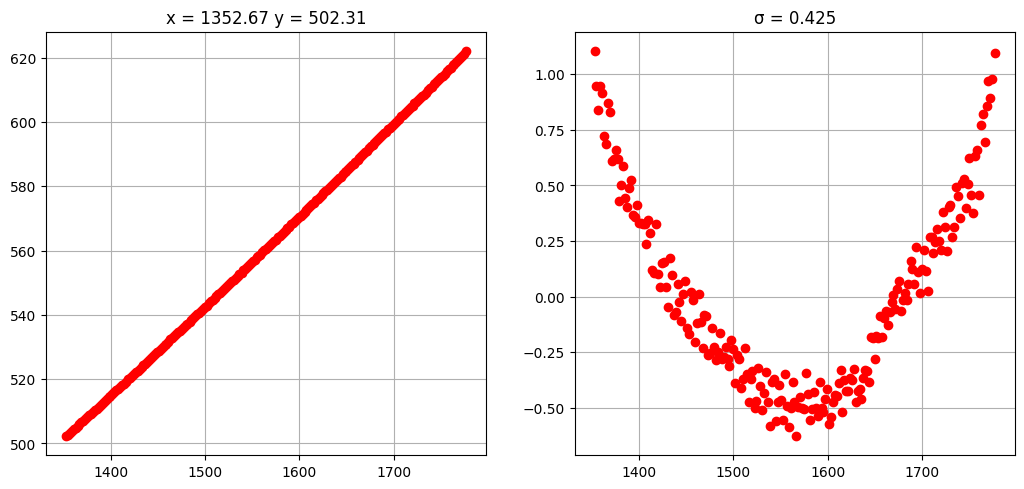

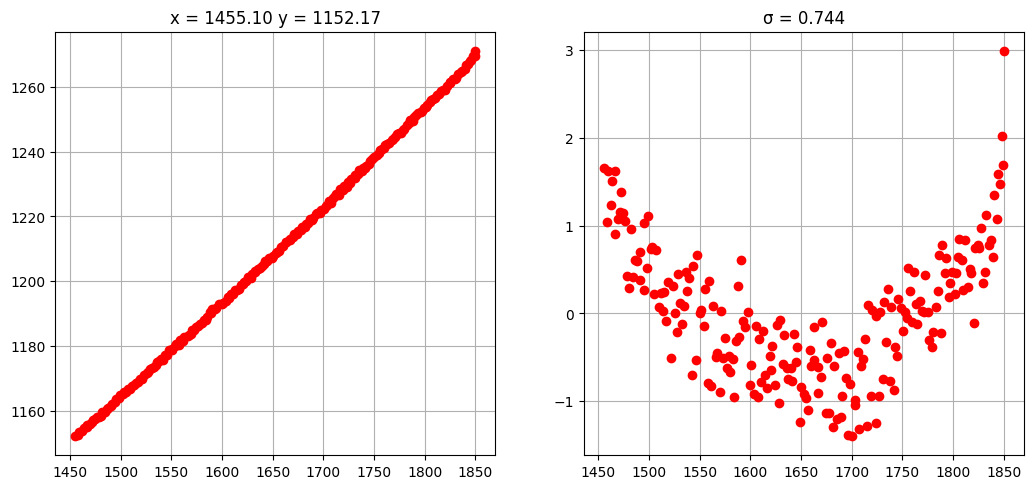

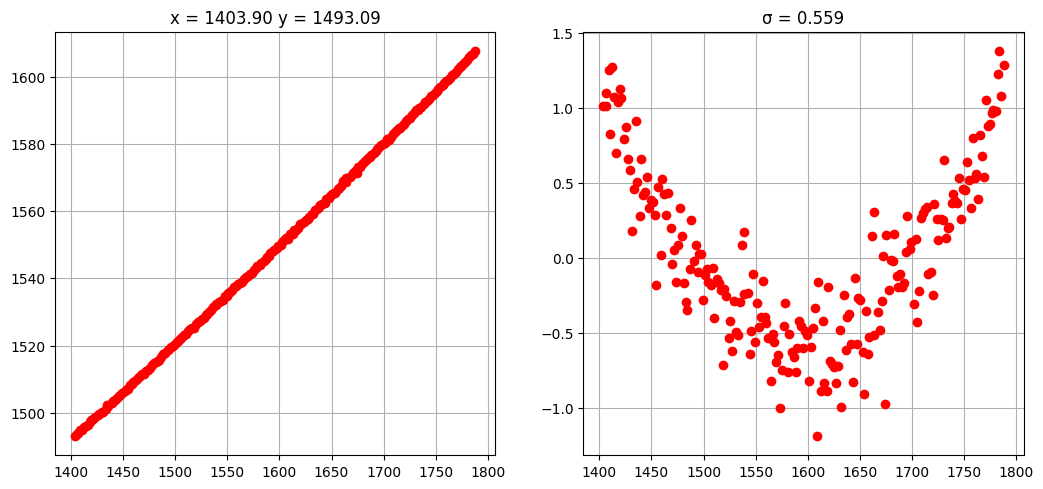

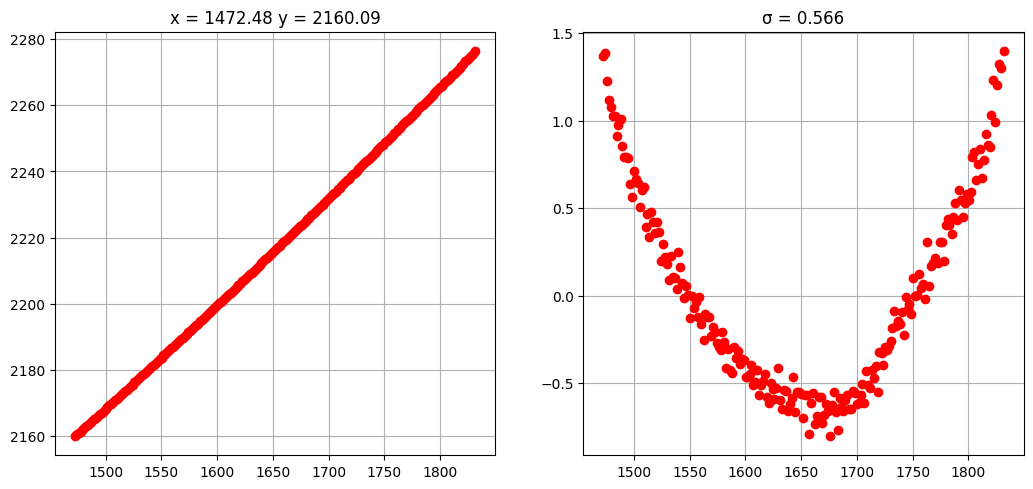

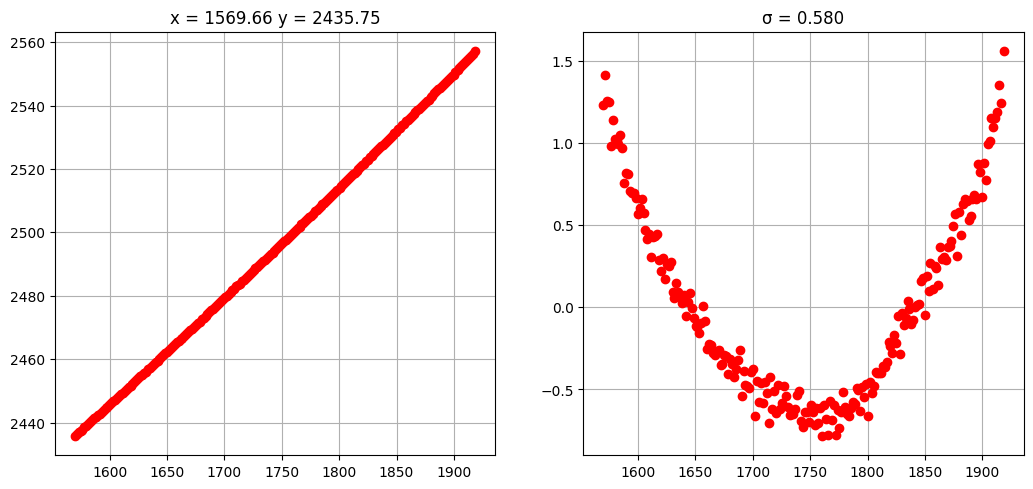

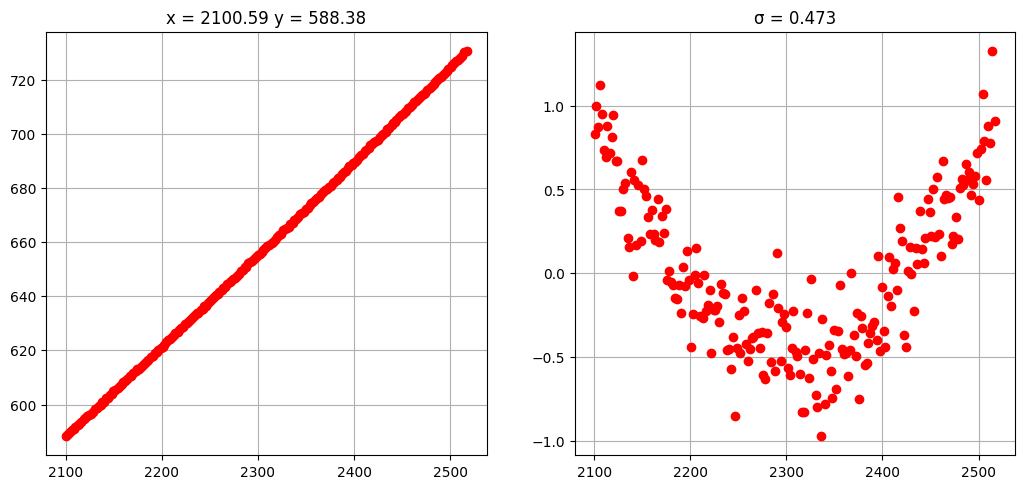

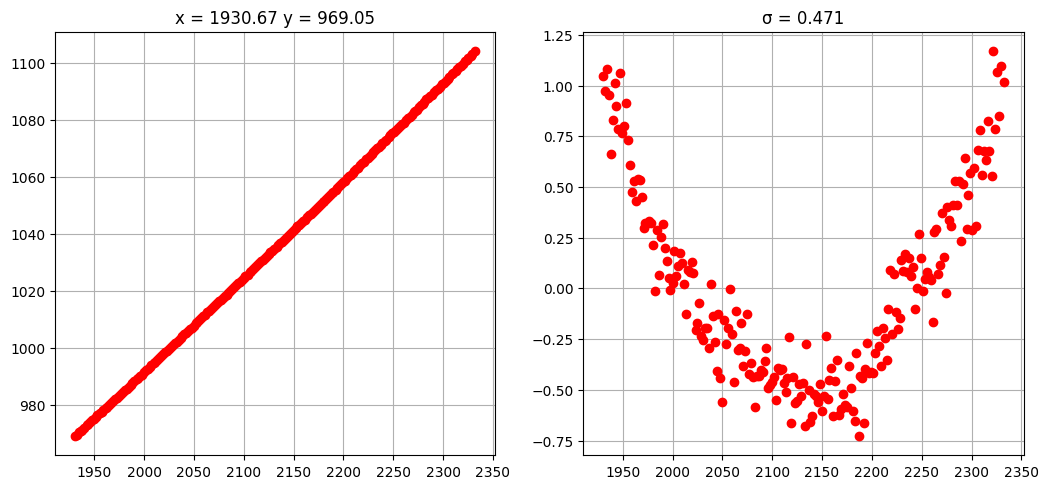

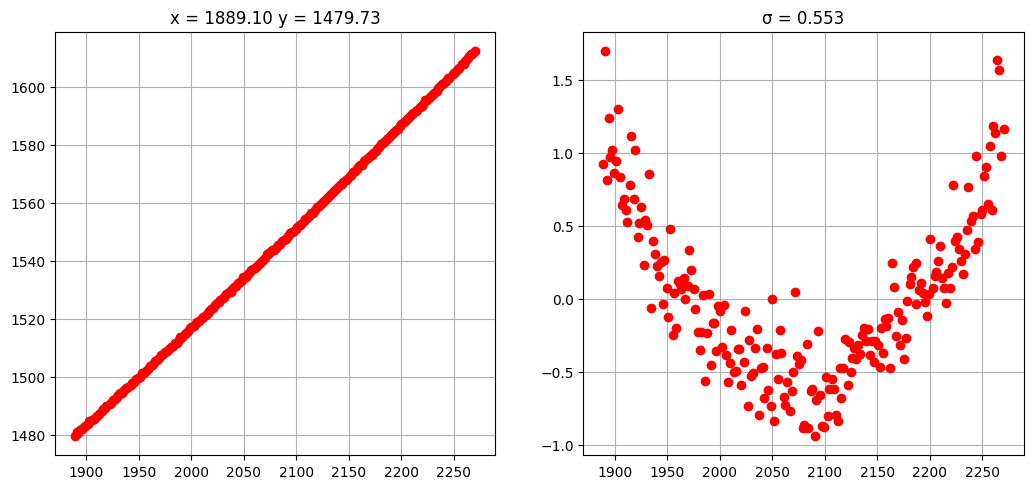

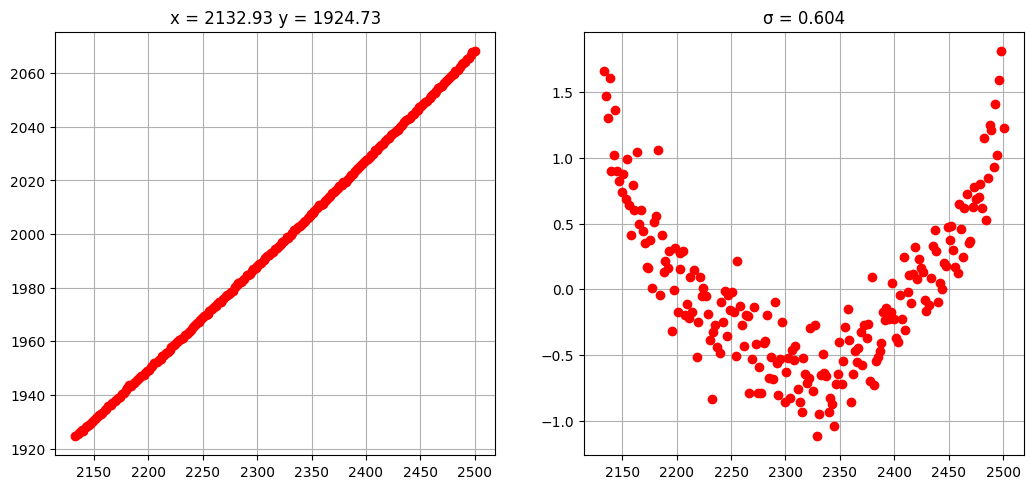

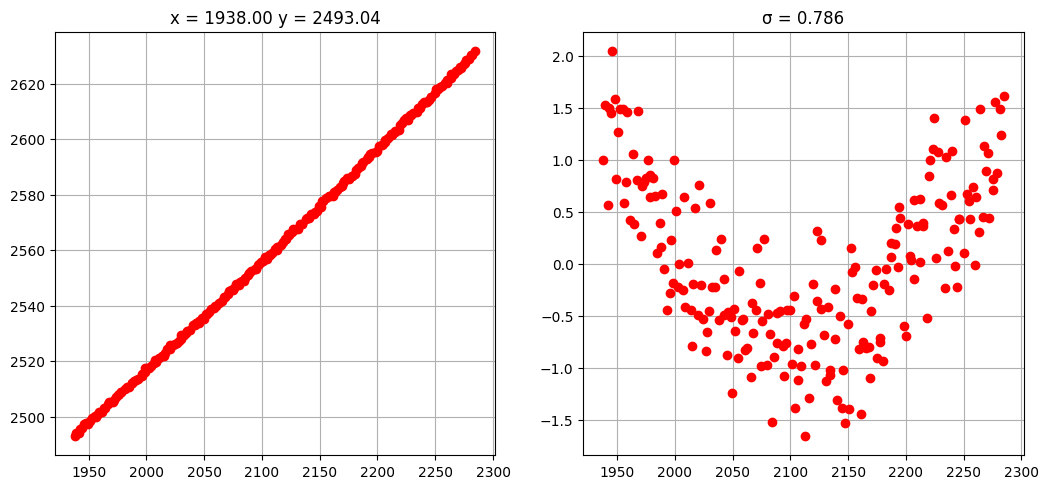

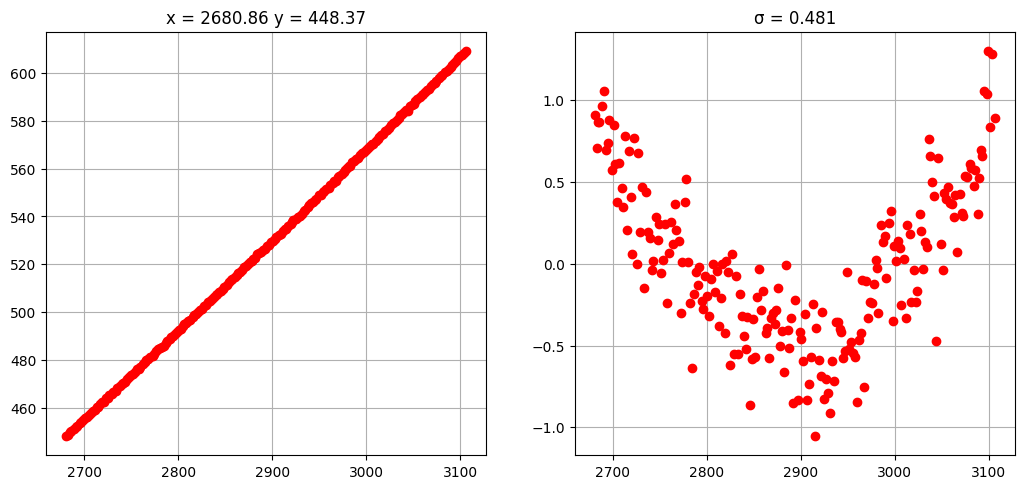

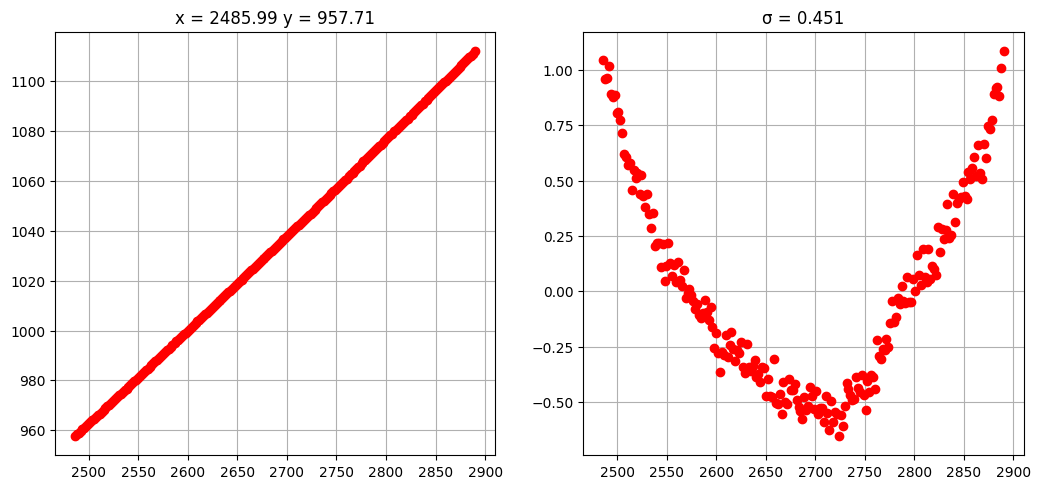

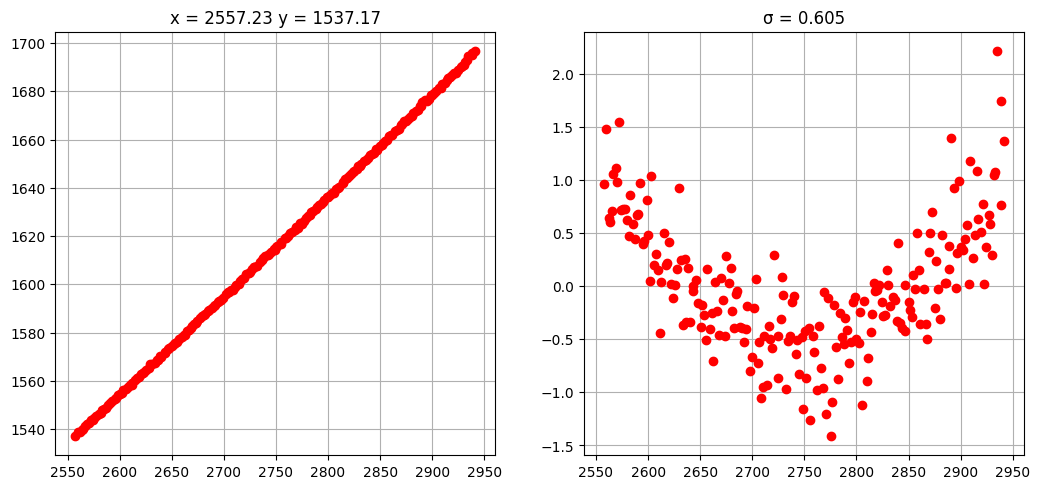

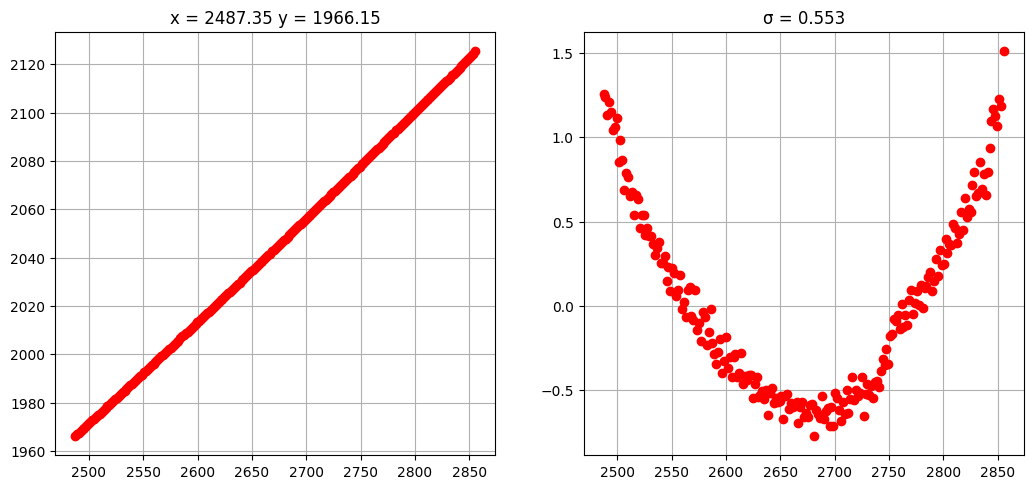

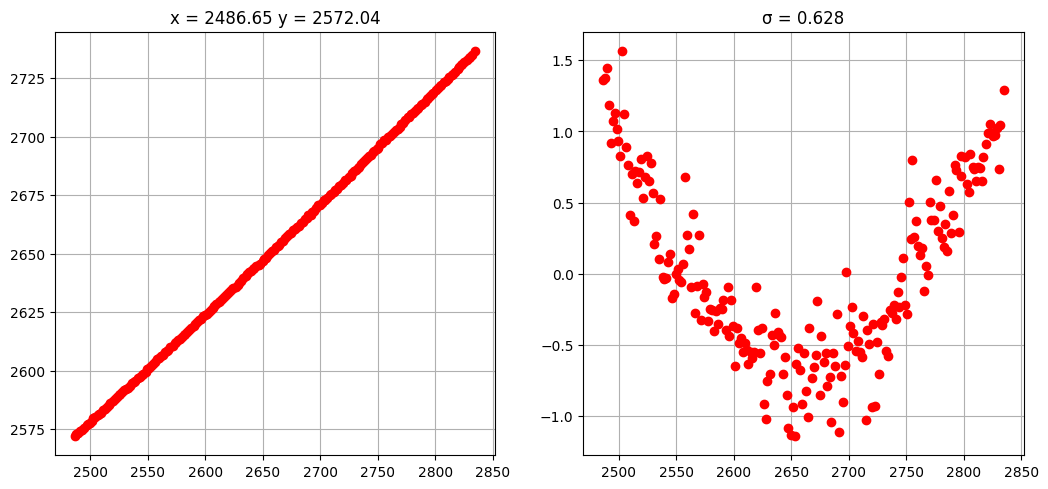

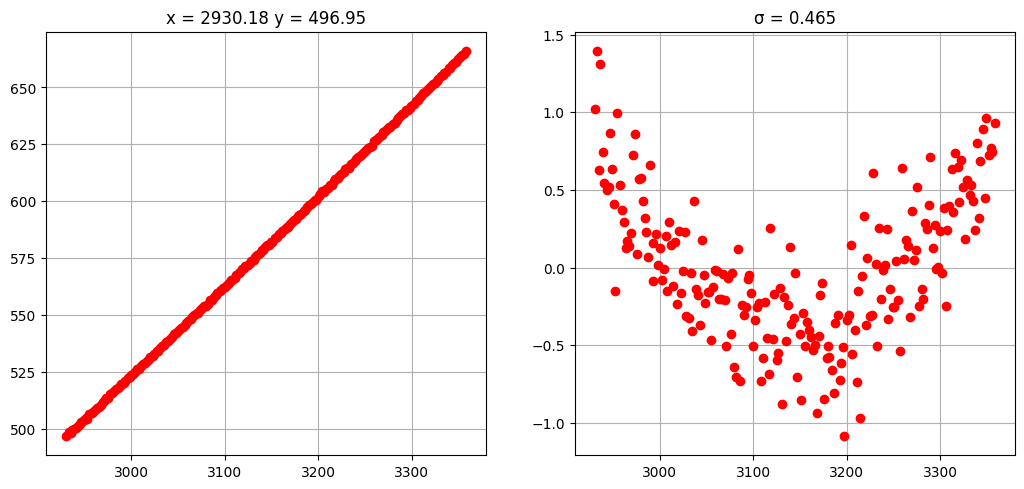

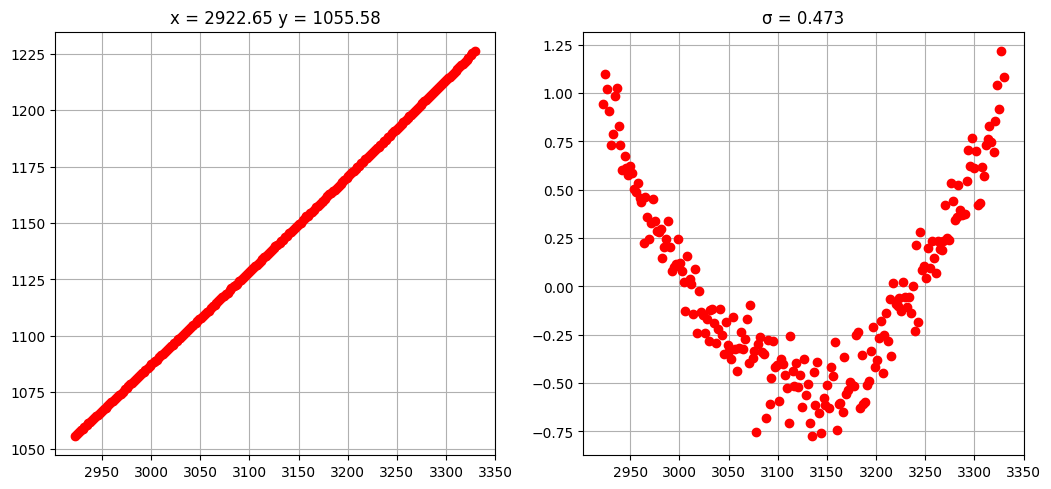

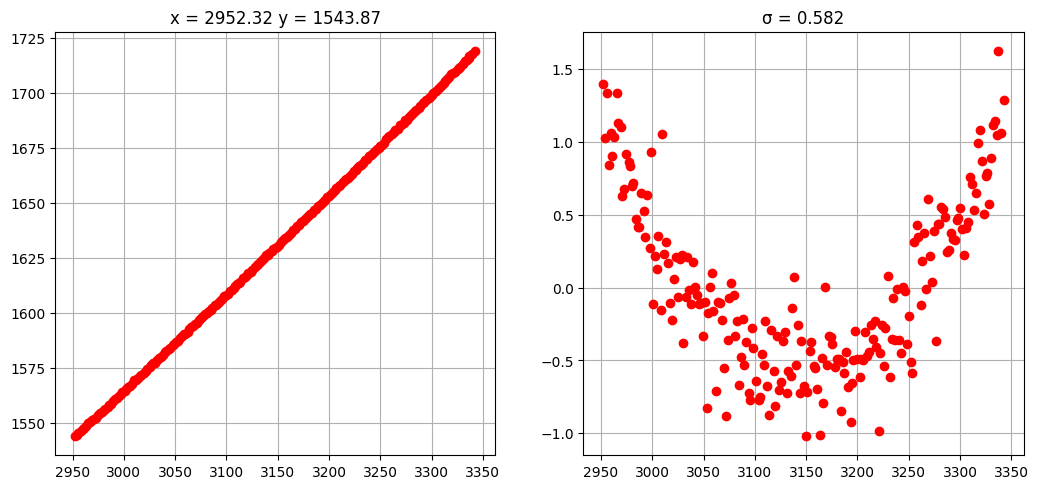

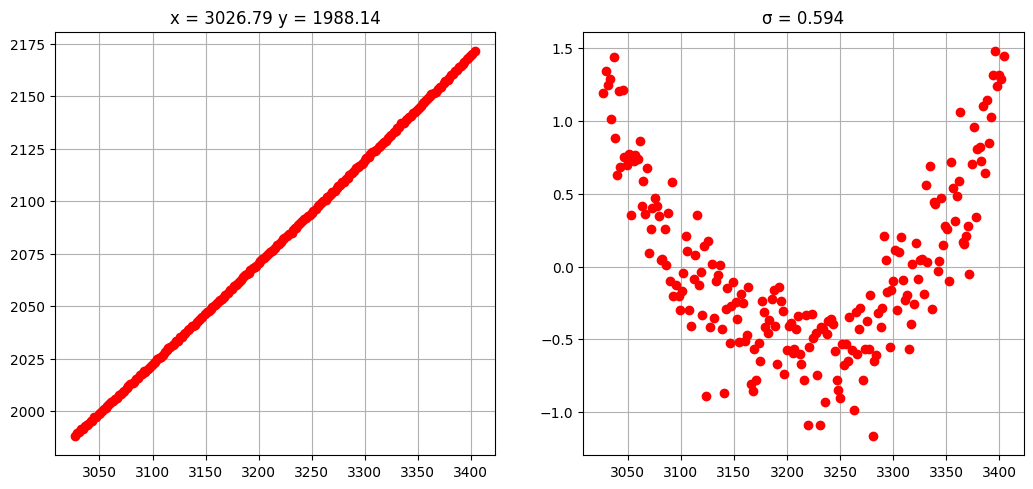

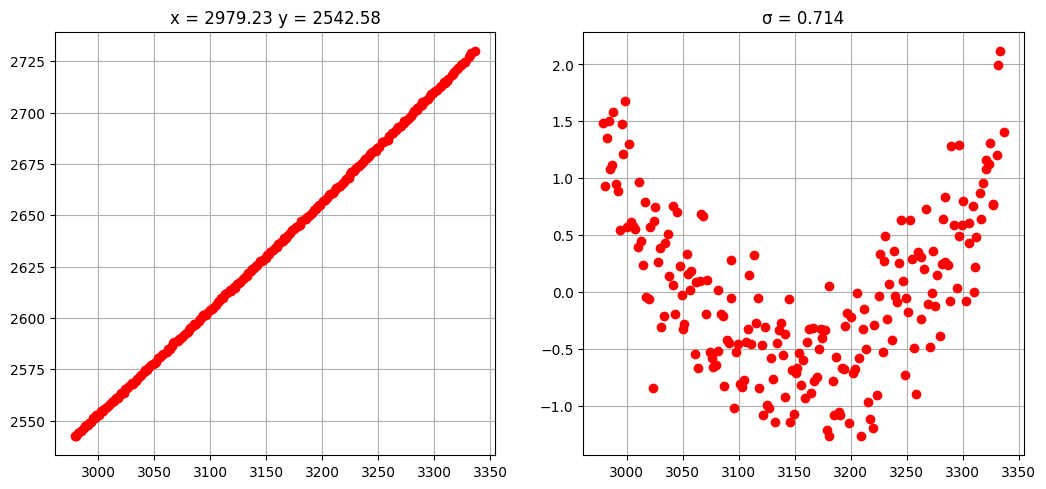

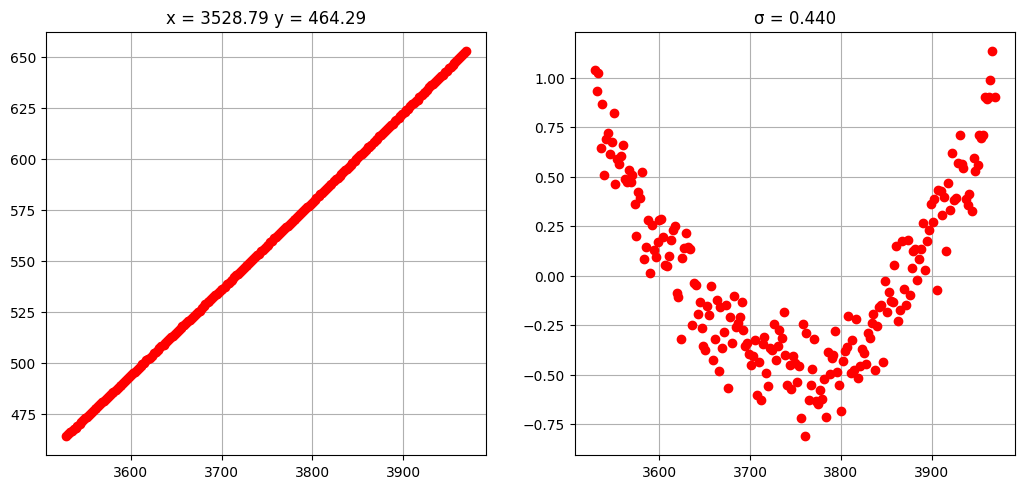

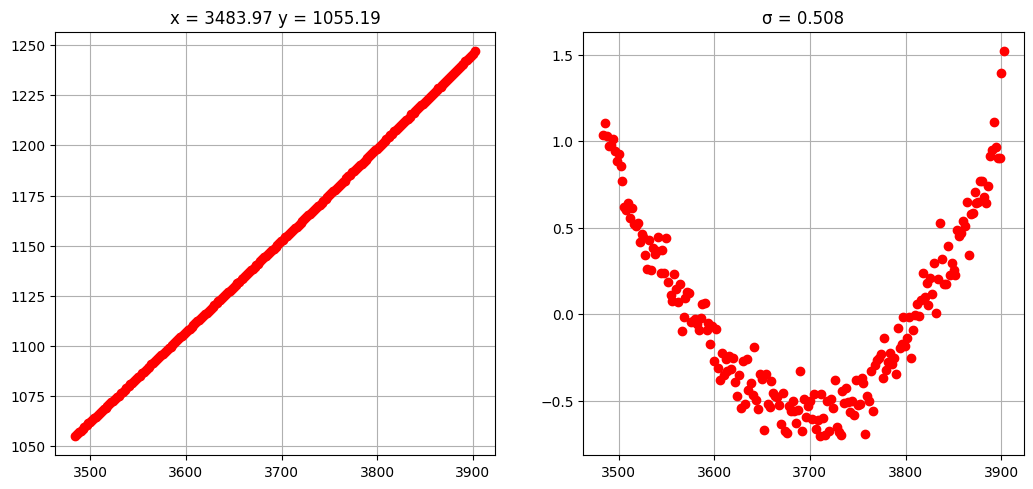

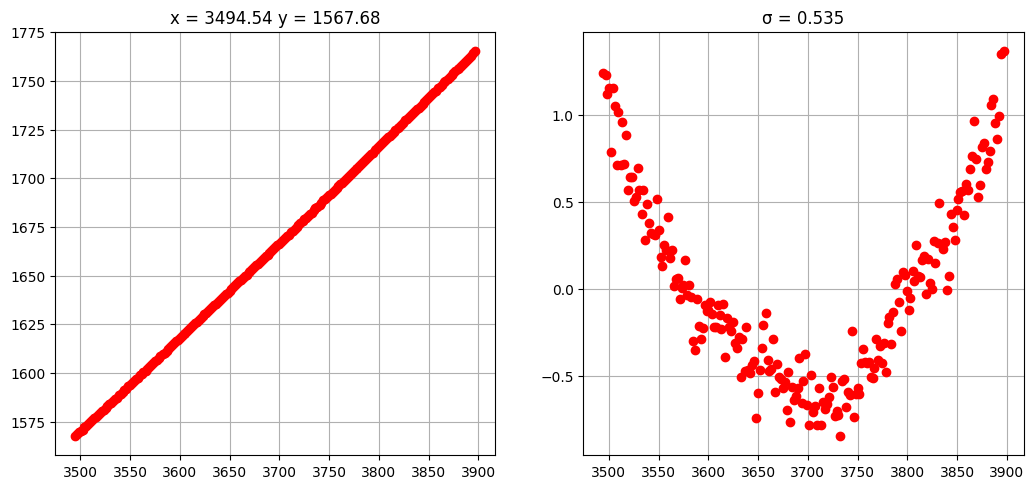

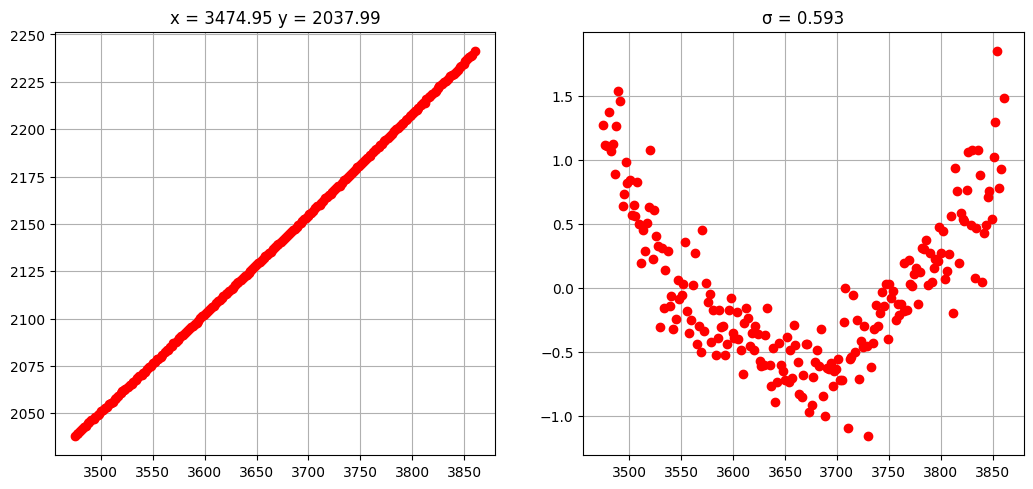

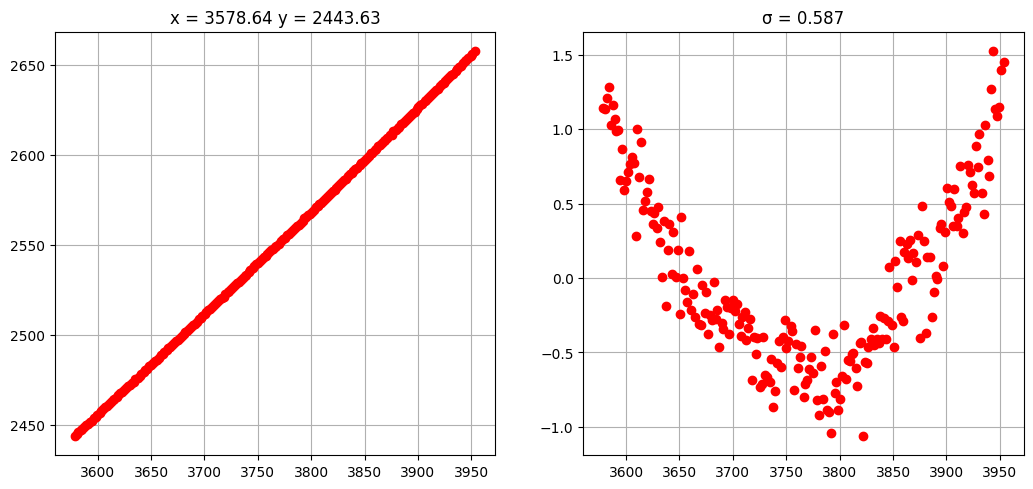

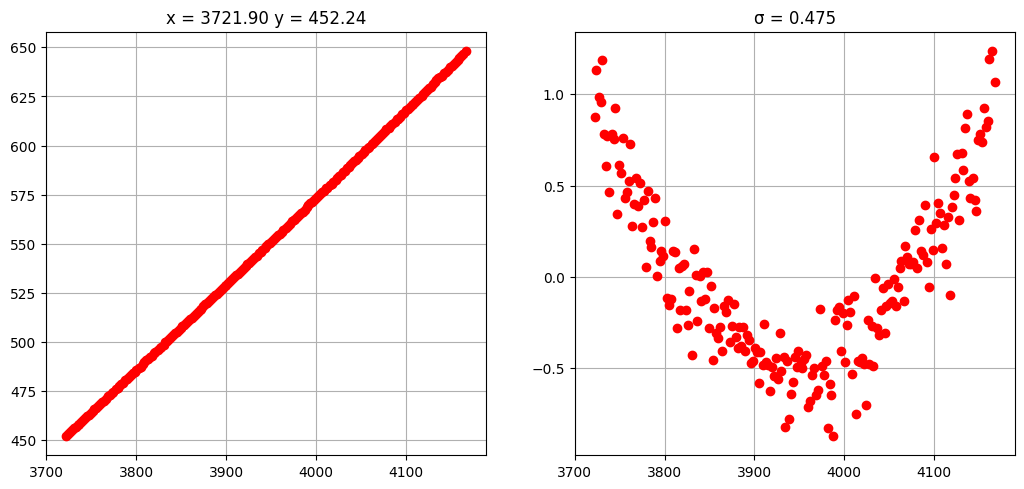

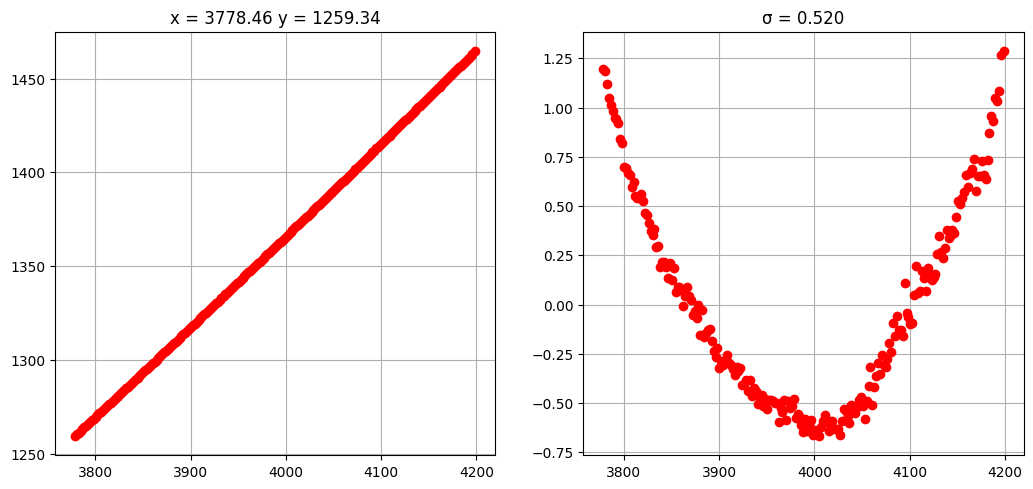

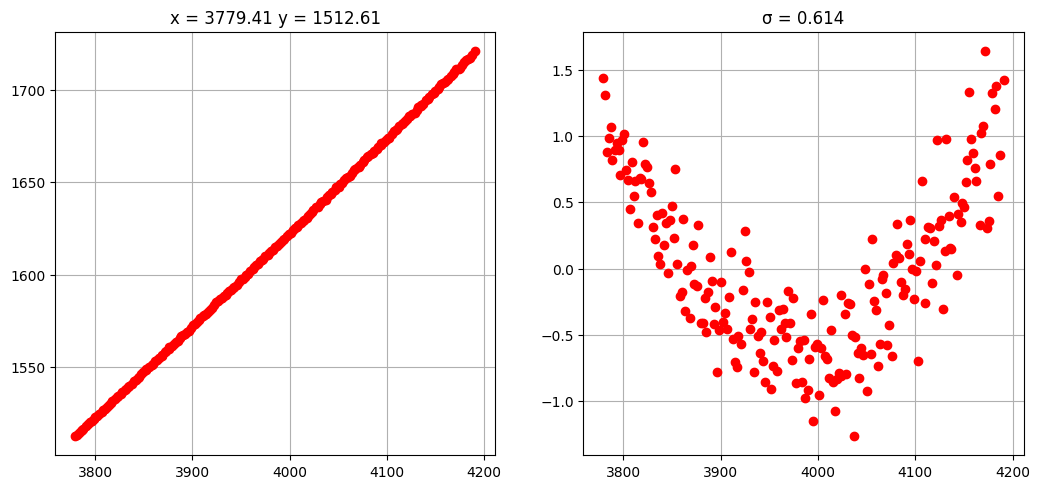

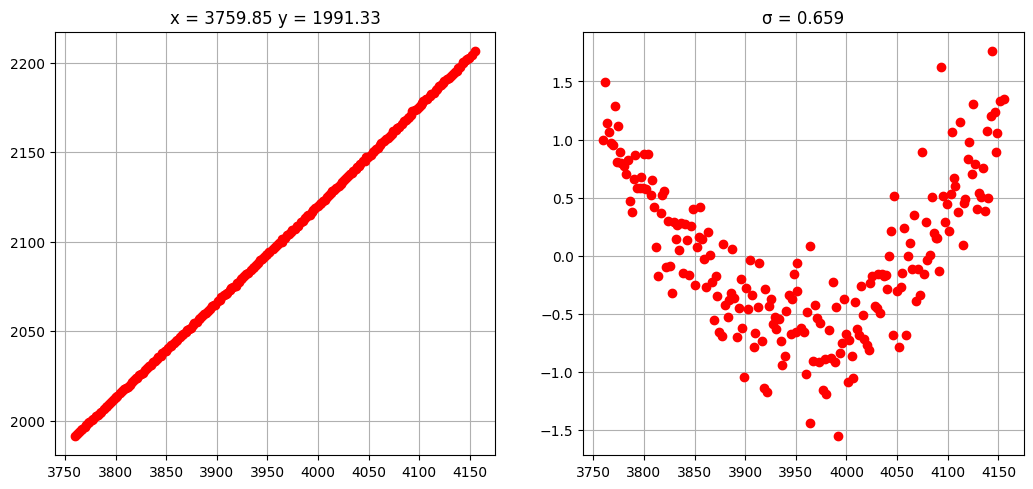

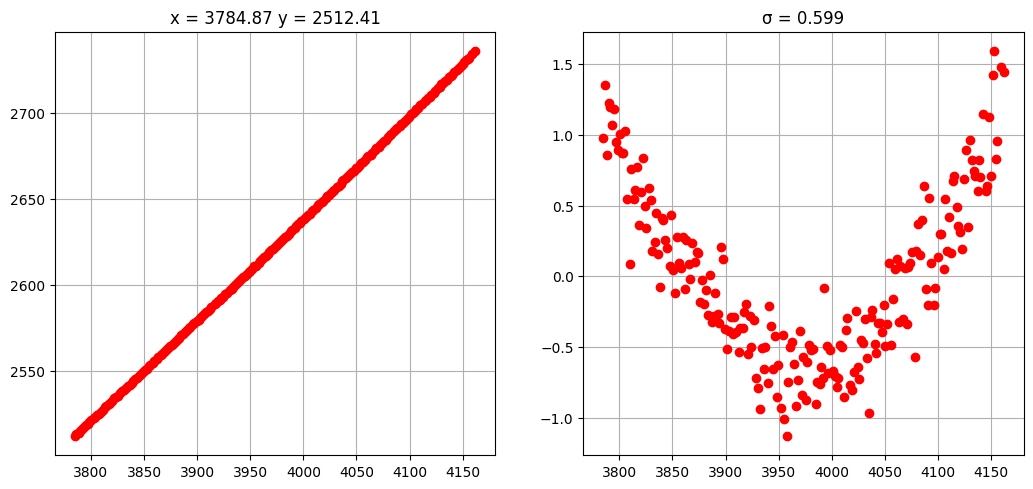

In [10]:
# step over evenly spaced positions in image, and pick nearest star for ploting.
step = 500
for x in range(step, nx, step):
    for y in range(step, ny, step):
        plot_residuals(x, y, table_list, nearest=True, large_resid=0.0) # only plot large residuals

## Reject stars

In [11]:
table_list_clean = reject_stars(table_list, residual_threshold=0.7)

48 2.17384992663145
100 1.0412842577524712
105 1.9711012827683045
107 0.743790447426256
108 0.7000194948105898
136 0.9322624057244872
160 0.7109370353821846
161 0.8140485722303119
164 0.7849410046809727
174 0.7763238988139972
177 0.7160766209482039
179 1.2060011263699328
183 0.9449398674780851
196 1.0336757865878932
217 0.7579941937722173
223 0.7452387157100897
253 0.7183514279204753
258 0.7857259473997377
268 0.7038494760782376
270 0.8934476966017545
272 0.9233011916394152
276 0.7140021456634149
277 0.7003437218990057
278 0.7130606711640834
280 1.0645966138827718
285 0.7146362063775852


In [12]:
table_list_clean[-1]

xcentroid,ycentroid,xoffset,yoffset,xoffset_prev,yoffset_prev,ref_row,prev_row
float64,float64,float64,float64,float64,float64,int64,int64
2357.8754970156133,0.26399987010444725,-441.8570298491413,-151.81596856561342,-2.3002234413575025,0.09162390832043002,53,0
1622.44003535615,37.08561542857559,-441.9429491463047,-132.63544789975498,-1.9129662993407237,-0.7638434637575386,65,1
3286.149065097795,22.534897114119612,-451.9390808834278,-179.71654063657982,-2.142527798274841,-0.7766557363841393,71,2
1635.8520447110905,69.73598822909513,-440.61102469416346,-132.89856900588387,-2.841555033419354,-0.6142250287829256,72,3
3209.5068124070253,26.349589163926133,-450.30703101718336,-177.34492755818985,-2.040662851758043,-0.6597829163494566,73,4
2010.086812603892,74.1223302345982,-438.9349938604662,-140.72967357384667,-2.6786436629204218,-0.7249969213663263,77,5
1499.9902282429462,95.35514002005947,-439.9521323149502,-128.37398529176215,-1.915474030199448,-0.6650882183107001,80,6
2959.414668720302,55.70114784990448,-445.15431523364987,-169.81191276070862,-1.9682303342929117,-0.7558624364853159,82,7
689.5855307309513,122.74953671331697,-452.8008460500704,-105.33170427121344,-2.0425030197931164,0.019056233806296063,83,8


In [13]:
table_list_clean[0]

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,xoffset,yoffset,xoffset_prev,yoffset_prev,ref_row,prev_row
int64,float64,float64,float64,float32,float64,int64,float32,float32,float64,float64,float64,float64,float64,float64,int64,int64
54,2799.7325268647546,152.07996843571786,0.7084207218504674,-0.17416358,-0.0977692494326027,49,-1.0742488,1429.0167,58.966426849365234,-4.426512029779456,0.0,0.0,0.0,0.0,53,53
66,2064.3829845024547,169.7210633283306,0.7338581773306845,-0.081334025,-0.05341864759557467,49,-1.0742488,1877.8362,60.71016836166382,-4.458153593154213,0.0,0.0,0.0,0.0,65,65
72,3738.0881459812226,202.25143775069944,0.5202341346338922,-0.19506457,-0.10498914525283894,49,-1.0742488,2993.5723,69.411292552948,-4.603575329396124,0.0,0.0,0.0,0.0,71,71
73,2076.463069405254,202.63455723497898,0.8649010415885477,-0.20357834,-0.08432729675212922,49,-1.0742488,874.5836,55.89395451545715,-4.368412092946815,0.0,0.0,0.0,0.0,72,72
74,3659.8138434242087,203.694516722116,0.6923864285071678,-0.007574506,0.01406213860865988,49,-1.0742488,3346.6853,67.60538530349731,-4.574953230772637,0.0,0.0,0.0,0.0,73,73
78,2449.021806464358,214.85200380844486,0.8569257102294752,-0.068598434,-0.09368062293521301,49,-1.0742488,879.79095,55.96949100494385,-4.36987839346169,0.0,0.0,0.0,0.0,77,77
81,1939.9423605578963,223.7291253118216,0.8654358366078667,0.0077902125,0.03430085365091462,49,-1.0742488,3238.6533,64.83649587631226,-4.529548837823033,0.0,0.0,0.0,0.0,80,80
83,3404.568983953952,225.5130606106131,0.34812331263304125,-0.2119304,-0.012055102358420795,49,-1.0742488,598.51263,57.14335489273071,-4.3924143356816,0.0,0.0,0.0,0.0,82,82
84,1142.3863767810217,228.0812409845304,0.5746484602765682,0.21210687,-0.05089451681634394,49,-1.0742488,655.4278,56.06424164772034,-4.371714880122951,0.0,0.0,0.0,0.0,83,83


## Write cleaned tables

In [14]:
for i, tname_in in enumerate(file_list):
    tname_out = tname_in.replace('.offsets_table.fits','.offsets_table_clean.fits')
    
    table_list_clean[i].write(tname_out, overwrite=True)
    print(tname_out)

/Users/busko/Projects/astrophotography_data/Andromeda_2022/104p105/ADSC09939.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/104p105/ADSC09940.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/104p105/ADSC09941.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/104p105/ADSC09942.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/104p105/ADSC09943.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/104p105/ADSC09944.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/104p105/ADSC09945.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/104p105/ADSC09946.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/104p105/ADSC09947.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/104p105/ADSC09948.offse

/Users/busko/Projects/astrophotography_data/Andromeda_2022/104p105/BADSC00045.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/104p105/BADSC00046.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/104p105/BADSC00047.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/104p105/BADSC00048.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/104p105/BADSC00049.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/104p105/BADSC00050.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/104p105/BADSC00051.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/104p105/BADSC00052.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/104p105/BADSC00053.offsets_table_clean.fits
/Users/busko/Projects/astrophotography_data/Andromeda_2022/104p105/BADSC0

## Check coverage

Plot remaining stars over image to see how much was removed, and where.

In [15]:
x0 = 0
x1 = imarray.shape[1]
y0 = 0
y1 = imarray.shape[0]

# x0 = 1800
# x1 = 2500
# y0 =  900
# y1 = 1700

aslice = np.index_exp[y0:y1, x0:x1]

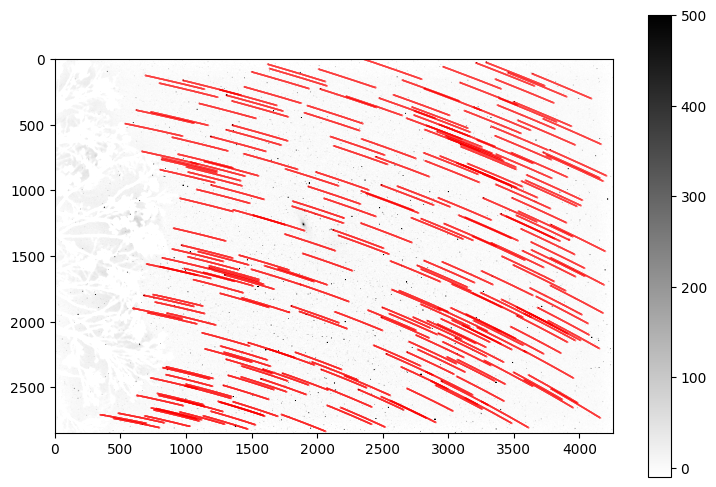

In [16]:
plt.figure(figsize=[9, 6])
plt.imshow(imarray[aslice], vmin=-10, vmax=500, cmap='binary')
plt.colorbar()

for table in table_list_clean:
    positions = [(x-x0,y-y0) for x,y in zip(table['xcentroid'], table['ycentroid'])]
    apertures = CircularAperture(positions, r=0.5)
    _ = apertures.plot(color='red')

## Conclusions

Most of the residuals from a linear fit are of the order of a few tenths of a pixel (14 mm lens) or smaller than the PSF FWHM (135 mm lens). Depending on the position of the star on the sky, a linear fit may or may not be a good approximation, so that may account for an increase in the residuals' rms. 